In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.optim import AdamW 

In [6]:
# 1. Load Dataset
df = pd.read_csv("C:/Users/abhis/OneDrive/Desktop/ML/BERT NLP Transformers/CustomerComplaintsSentiment and PriorityDataset.csv")
print(df.shape)
df.head()

(1750, 4)


,Consumer_complaint,Product,Sentiment,Priority
0,I had overdraft protection with Regions Bank i...,Checking or savings account or service,0,1
1,"I am the sole, legal representative of my dece...",Checking or savings account or service,0,1
2,This bank has consistantly manipulated my dire...,Checking or savings account or service,0,0
3,I enrolled in a Citibank checking account in X...,Checking or savings account or service,0,1
4,TIAA-XXXX has not responded to multiple reque...,Checking or savings account or service,0,1


In [7]:
#clear

In [8]:
# Drop rows with missing complaints or sentiments
df = df.dropna(subset=['Consumer_complaint', 'Sentiment'])

# Just keep relevant columns
df = df[['Consumer_complaint', 'Sentiment']]

# Check class balance
print(df['Sentiment'].value_counts())


0    1295
1     455
Name: Sentiment, dtype: int64


In [9]:
#Tokenize with BERT

In [10]:
# pip install transformers datasets

In [11]:
# pip install torch

In [12]:
# pip install torch transformers datasets sklearn matplotlib seaborn tqdm

In [13]:
#Dataset for BERT

In [14]:
class ComplaintsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [15]:
# Train-Test Split

In [16]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Consumer_complaint'],
    df['Sentiment'],
    test_size=0.2,
    random_state=42
)

train_dataset = ComplaintsDataset(train_texts.tolist(), train_labels.tolist(), tokenizer, max_len=128)
val_dataset = ComplaintsDataset(val_texts.tolist(), val_labels.tolist(), tokenizer, max_len=128)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)


In [21]:
optimizer = AdamW(model.parameters(), lr=2e-5)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = model.to(device)


In [22]:
epochs = 3

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, leave=True)
    
    for batch in loop:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        
        loss = outputs.loss
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
        loop.set_description(f'Epoch {epoch+1}')
        loop.set_postfix(loss=loss.item())
        
    print(f"Epoch {epoch+1} Loss: {total_loss/len(train_loader)}")


Epoch 1: 100%|██████████| 88/88 [09:48<00:00,  6.69s/it, loss=0.398]


Epoch 1 Loss: 0.5536817532371391


Epoch 2: 100%|██████████| 88/88 [09:39<00:00,  6.59s/it, loss=0.303]


Epoch 2 Loss: 0.4994576746089892


Epoch 3: 100%|██████████| 88/88 [09:26<00:00,  6.44s/it, loss=0.157] 

Epoch 3 Loss: 0.40134977109052916


In [23]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Validation Accuracy: 0.7171
              precision    recall  f1-score   support

           0       0.74      0.92      0.82       245
           1       0.57      0.25      0.34       105

    accuracy                           0.72       350
   macro avg       0.65      0.58      0.58       350
weighted avg       0.69      0.72      0.68       350



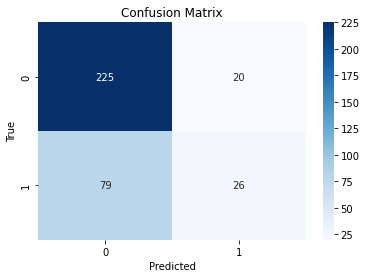

In [24]:
# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"Validation Accuracy: {accuracy:.4f}")

# Classification Report
print(classification_report(all_labels, all_preds))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [25]:
model.save_pretrained("./bert-sentiment-model")
tokenizer.save_pretrained("./bert-sentiment-model")


('./bert-sentiment-model\\tokenizer_config.json',
 './bert-sentiment-model\\special_tokens_map.json',
 './bert-sentiment-model\\vocab.txt',
 './bert-sentiment-model\\added_tokens.json')